In [1]:
!pip install pandas numpy nltk gensim scikit-learn pyLDAvis spacy

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import os
import re
import json
import numpy as np
import pandas as pd

In [4]:
import pandas as pd

# Replace the file name with your dataset path if different
df = pd.read_csv("final_fulldataset_1.csv")

# Check the first few rows
df.head()

,Unnamed: 0,critic_name,rotten_tomatoes_link,movie_title,content_rating,genres,original_release_date,review_score,review_content,movie_info
0,3,ben mceachen,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,70.0,whether audiences will get behind the lightnin...,"always trouble-prone, the life of teenager per..."
1,6,nick schager,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,25.0,harry potter knockoffs don't come more transpa...,"always trouble-prone, the life of teenager per..."
2,7,bill goodykoontz,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,70.0,"percy jackson isn't a great movie, but it's a ...","always trouble-prone, the life of teenager per..."
3,8,jordan hoffman,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,83.0,"fun, brisk and imaginative","always trouble-prone, the life of teenager per..."
4,9,jim schembri,m/0814255,percy jackson & the olympians: the lightning t...,pg,"action & adventure, comedy, drama, science fic...",2010,60.0,"crammed with dragons, set-destroying fights an...","always trouble-prone, the life of teenager per..."


In [5]:
# Aggregate by link, keep title as part of the document and keep link as the ID
df["rotten_tomatoes_link"] = df["rotten_tomatoes_link"].str.strip()
df["combined_review"] =  df["review_content"].fillna("")

reviews_agg = df.groupby("rotten_tomatoes_link").agg({

    "movie_title": lambda x: x.dropna().astype(str).mode().iat[0],
    "original_release_date": lambda x: x.dropna().astype(str).mode().iat[0],
    "movie_info": lambda x: x.dropna().astype(str).mode().iat[0],
    "genres": lambda x: ", ".join(sorted({
        g.strip()
        for g in ",".join(x.dropna().astype(str)).split(",")
        if g.strip()
    })),
    "combined_review": lambda x: " ".join(x.dropna().astype(str))   # moved to last
    
}).reset_index().rename(columns={
    "rotten_tomatoes_link": "movie_link",
    "original_release_date": "year"
})

# ----------------------------------------------
# Reorder columns so combined_review is last
# ----------------------------------------------
cols = [c for c in reviews_agg.columns if c != "combined_review"] + ["combined_review"]
reviews_agg = reviews_agg[cols]

# ----------------------------------------------
# Display sample rows
# ----------------------------------------------
reviews_agg.head()

,movie_link,movie_title,year,movie_info,genres,combined_review
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"always trouble-prone, the life of teenager per...","action & adventure, comedy, drama, science fic...",whether audiences will get behind the lightnin...
1,m/0878835,please give,2010,kate (catherine keener) and her husband alex (...,comedy,holofcener always gives us more to chew on tha...
2,m/10,10,1979,"a successful, middle-aged hollywood songwriter...","comedy, romance",obvious but entertaining portrayal of midlife ...
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,following the closing arguments in a murder tr...,"classics, drama",in a time of bloated when special effects have...
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"in 1866, professor pierre m. aronnax (paul luk...","action & adventure, drama, kids & family",[the] embodiment of disney at his best -- fami...


In [6]:
# Check how many times each movie_link appears
link_counts = reviews_agg['movie_link'].value_counts()
# Check how many times each movie_title appears
title_counts = reviews_agg['movie_title'].value_counts()

# Find links that appear more than once
duplicate_links = link_counts[link_counts > 1]
duplicate_titles= title_counts[title_counts > 1]

print(f"Number of movie_links appearing more than once: {len(duplicate_links)}")
print(f"Number of movie_titles appearing more than once: {len(duplicate_titles)}")

Number of movie_links appearing more than once: 0
Number of movie_titles appearing more than once: 17


In [7]:
# Find all movie titles that appear more than once
duplicate_titles = reviews_agg["movie_title"].value_counts()
duplicate_titles = duplicate_titles[duplicate_titles > 1]

duplicate_titles

movie_title
phantom of the opera                          2
babes in toyland                              2
all the king's men                            2
the art of the steal                          2
house on haunted hill                         2
invaders from mars                            2
don't be afraid of the dark                   2
born to be wild                               2
beauty and the beast (la belle et la bête)    2
out of the dark                               2
a star is born                                2
a farewell to arms                            2
murder on the orient express                  2
our brand is crisis                           2
rocketman                                     2
the secret life of walter mitty               2
take me to the river                          2
Name: count, dtype: int64

In [8]:
# Show full duplicate entries with their reviews
duplicate_entries = reviews_agg[reviews_agg["movie_title"].isin(duplicate_titles.index)]

duplicate_entries

,movie_link,movie_title,year,movie_info,genres,combined_review
35,m/10004835-farewell_to_arms,a farewell to arms,1957,"based on the ernest hemingway novel, this worl...","classics, drama, romance",we have david o. selznick to blame for this bl...
60,m/1000654-all_the_kings_men,all the king's men,1949,drama about the rise and fall of a corrupt sou...,"classics, drama",rossen's film chronicles this life of raw powe...
290,m/1001488-babes_in_toyland,babes in toyland,1961,mary contrary (annette) is set to marry tom pi...,"kids & family, musical & performing arts, roma...",a disgrace to the memory of laurel and hardy a...
296,m/1001902-beauty_and_the_beast,beauty and the beast (la belle et la bête),1946,the story of a gentle-hearted beast in love wi...,"drama, romance, science fiction & fantasy",one of the most magical of all films. jean coc...
477,m/1010034-house_on_haunted_hill,house on haunted hill,1959,rich oddball frederick loren (vincent price) h...,"classics, drama, horror",giddy and fun... and scary if you're in the ri...
492,m/1010672-invaders_from_mars,invaders from mars,1953,curious adolescent boy david maclean (jimmy hu...,"classics, science fiction & fantasy","an enjoyable b-movie, but not quite as good as..."
493,m/1010673-invaders_from_mars,invaders from mars,1986,a boy (hunter carson) sees his parents and nei...,"horror, mystery & suspense, science fiction & ...",a clunky remake that fails to frighten fun and...
604,m/1015753-out_of_the_dark,out of the dark,1989,an employee at a telephone fantasy service hel...,"comedy, drama, horror, mystery & suspense",the identity of the murderer is a contrived su...
611,m/1016240-phantom_of_the_opera,phantom of the opera,1925,composer lord ambrose d'arcy (michael gough) a...,"classics, drama, horror","chaney is so effective, it is nearly impossibl..."
699,m/1019828-star_is_born,a star is born,1937,when a young actress (janet gaynor) arrives in...,"classics, drama",william a. wellman's original 1937 a star is b...


In [9]:
# Create a combined text column for embeddings
reviews_agg['text_for_embedding'] = (
    reviews_agg['movie_title'].fillna('') + ' ' +
    reviews_agg['movie_info'].fillna('')+' '+
    reviews_agg['combined_review'].fillna('')
).str.strip()

# Keep relevant columns for embeddings including movie_title
embedding_df = reviews_agg[['movie_link', 'movie_title', 'year','genres', 'text_for_embedding']].copy()

# Check a few rows
print("Sample of combined text for embedding:")
display(embedding_df.head(5))

Sample of combined text for embedding:


,movie_link,movie_title,year,genres,text_for_embedding
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"action & adventure, comedy, drama, science fic...",percy jackson & the olympians: the lightning t...
1,m/0878835,please give,2010,comedy,please give kate (catherine keener) and her hu...
2,m/10,10,1979,"comedy, romance","10 a successful, middle-aged hollywood songwri..."
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,"classics, drama",12 angry men (twelve angry men) following the ...
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"action & adventure, drama, kids & family","20,000 leagues under the sea in 1866, professo..."


In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
import re

# -----------------------------------------
# 1. Setup stopwords
# -----------------------------------------
stop_words = set(stopwords.words('english'))
extra_stopwords = {"movie", "film", "films", "story", "character"}
stop_words.update(extra_stopwords)

# -----------------------------------------
# 2. Lemmatizer
# -----------------------------------------
lemmatizer = WordNetLemmatizer()

# -----------------------------------------
# 3. Cleaning (NO ANIME/ANIMATION FIX)
# -----------------------------------------
def clean_text(text):
    # Keep letters only
    text = re.sub(r"[^a-zA-Z ]", " ", text)
    text = text.lower()
    return text

# -----------------------------------------
# 4. Tokenization + Lemmatization
# -----------------------------------------
def preprocess(text):
    tokens = simple_preprocess(text, deacc=True)

    # Remove stopwords + short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

# -----------------------------------------
# 5. Apply to dataset
# -----------------------------------------
embedding_df["cleaned_text"] = embedding_df["text_for_embedding"].apply(clean_text)
embedding_df["tokens"] = embedding_df["cleaned_text"].apply(preprocess)

embedding_df[["movie_link", "movie_title","year", "genres", "tokens"]].head()

,movie_link,movie_title,year,genres,tokens
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"action & adventure, comedy, drama, science fic...","[percy, jackson, olympian, lightning, thief, a..."
1,m/0878835,please give,2010,comedy,"[please, give, kate, catherine, keener, husban..."
2,m/10,10,1979,"comedy, romance","[successful, middle, aged, hollywood, songwrit..."
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,"classics, drama","[angry, men, twelve, angry, men, following, cl..."
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"action & adventure, drama, kids & family","[league, sea, professor, pierre, aronnax, paul..."


In [11]:
from gensim.corpora import Dictionary

# Create dictionary from tokens
dictionary = Dictionary(embedding_df["tokens"])

# Filter very rare and very frequent words
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in embedding_df["tokens"]]

print("Dictionary size:", len(dictionary))
print("Example BOW for first movie:", corpus[0][:10])

Dictionary size: 21998
Example BOW for first movie: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 8), (5, 3), (6, 1), (7, 1), (8, 7), (9, 1)]


In [13]:
from gensim.models.ldamodel import LdaModel

num_topics = 30

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    chunksize=2000,
    update_every=1,
    alpha='auto',
    eta='auto'
)

lda_model.print_topics(num_topics=10)

[(np.int64(12),
  '0.065*"white" + 0.053*"ben" + 0.041*"cage" + 0.034*"russell" + 0.033*"abrams" + 0.027*"crowe" + 0.027*"stiller" + 0.023*"owen" + 0.020*"nicolas" + 0.019*"snow"'),
 (np.int64(10),
  '0.129*"jack" + 0.071*"mike" + 0.051*"howard" + 0.045*"vaughn" + 0.034*"sarah" + 0.031*"ted" + 0.031*"jon" + 0.026*"leigh" + 0.022*"nicholson" + 0.021*"baker"'),
 (np.int64(25),
  '0.029*"man" + 0.019*"comic" + 0.017*"spider" + 0.017*"superhero" + 0.015*"book" + 0.013*"marvel" + 0.011*"anderson" + 0.011*"fun" + 0.008*"best" + 0.008*"men"'),
 (np.int64(26),
  '0.075*"paul" + 0.033*"lewis" + 0.032*"hitchcock" + 0.027*"wood" + 0.026*"tower" + 0.024*"theron" + 0.016*"joan" + 0.015*"lynch" + 0.013*"marsh" + 0.013*"sleep"'),
 (np.int64(11),
  '0.048*"adam" + 0.041*"sandler" + 0.032*"wild" + 0.027*"animal" + 0.021*"food" + 0.020*"murphy" + 0.018*"eddie" + 0.015*"ice" + 0.014*"herzog" + 0.013*"payne"'),
 (np.int64(27),
  '0.013*"life" + 0.011*"family" + 0.008*"heart" + 0.008*"young" + 0.007*"age" 

In [14]:
# Check genre column
embedding_df["genres"] = embedding_df["genres"].fillna("").astype(str)

embedding_df["genre_list"] = embedding_df["genres"].apply(
    lambda x: [g.strip() for g in x.split(",")] if x.strip() else []
)

print("Sample genres (raw):")
display(embedding_df["genres"].iloc[:5])
print("Sample genre_list (raw):")
display(embedding_df["genre_list"].iloc[:5])

Sample genres (raw):


0    action & adventure, comedy, drama, science fic...
1                                               comedy
2                                      comedy, romance
3                                      classics, drama
4             action & adventure, drama, kids & family
Name: genres, dtype: object

Sample genre_list (raw):


0    [action & adventure, comedy, drama, science fi...
1                                             [comedy]
2                                    [comedy, romance]
3                                    [classics, drama]
4           [action & adventure, drama, kids & family]
Name: genre_list, dtype: object

In [15]:
# list unique raw tokens and counts for inspection
from collections import Counter
flat = [g.strip() for lst in embedding_df['genre_list'] for g in lst if isinstance(g, str) and g.strip()]
genre_counts = Counter(flat)
import pandas as pd
genre_df = pd.DataFrame.from_records(list(genre_counts.items()), columns=['genre_raw','count']).sort_values('count', ascending=False).reset_index(drop=True)
print("Unique raw genres:", len(genre_df))
display(genre_df.head(80))

Unique raw genres: 21


,genre_raw,count
0,drama,8671
1,comedy,5161
2,action & adventure,3174
3,mystery & suspense,3151
4,art house & international,2267
5,documentary,1789
6,romance,1764
7,horror,1730
8,science fiction & fantasy,1681
9,classics,1547


In [16]:
# -----------------------------------------
# Genre Normalization Map
# -----------------------------------------
genre_map = {
    "art house & international": "international",
    "special interest": "documentary",
    "faith & spirituality": "drama",
    "gay & lesbian": "romance",
    "anime & manga": "manga",
}

# Genres to completely drop
drop_genres = {"cult movies"}

# -----------------------------------------
# Apply the mapping
# -----------------------------------------
def normalize_genre_list(genre_list):
    cleaned = []

    for g in genre_list:
        g = g.strip().lower()

        # Drop unwanted genres
        if g in drop_genres:
            continue

        # Replace using the mapping
        if g in genre_map:
            cleaned.append(genre_map[g])
        else:
            cleaned.append(g)

    return cleaned

# Apply to your dataframe
embedding_df["genre_list"] = embedding_df["genre_list"].apply(normalize_genre_list)

# Optional: check new distribution
from collections import Counter
flat = [g for lst in embedding_df["genre_list"] for g in lst]
Counter(flat)

Counter({'drama': 8742,
         'comedy': 5161,
         'action & adventure': 3174,
         'mystery & suspense': 3151,
         'documentary': 2927,
         'international': 2267,
         'romance': 1833,
         'horror': 1730,
         'science fiction & fantasy': 1681,
         'classics': 1547,
         'kids & family': 995,
         'musical & performing arts': 909,
         'animation': 529,
         'western': 282,
         'television': 201,
         'sports & fitness': 162,
         'manga': 18})

In [17]:
# -----------------------------------------
# 1. Compute per-document topic distributions
# -----------------------------------------
import numpy as np
import pandas as pd

# Function to get dense topic vector from LDA for a single document
def get_topic_vector(bow, num_topics=num_topics):
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
    # Convert to dense vector
    vec = np.zeros(num_topics)
    for topic_id, prob in topic_dist:
        vec[topic_id] = prob
    return vec

# Apply to all documents in embedding_df
topic_vectors = [get_topic_vector(bow) for bow in corpus]  # corpus is your BoW corpus

# Convert to DataFrame and assign topic columns
topic_cols = [f"Topic_{i}" for i in range(num_topics)]
topic_df = pd.DataFrame(topic_vectors, columns=topic_cols)

# Merge topic columns into embedding_df
embedding_df = pd.concat([embedding_df.reset_index(drop=True), topic_df], axis=1)

# inspect
embedding_df.head()


,movie_link,movie_title,year,genres,text_for_embedding,cleaned_text,tokens,genre_list,Topic_0,Topic_1,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,"action & adventure, comedy, drama, science fic...",percy jackson & the olympians: the lightning t...,percy jackson the olympians the lightning t...,"[percy, jackson, olympian, lightning, thief, a...","[action & adventure, comedy, drama, science fi...",0.270608,0.094149,...,0.000037,0.006122,0.062962,0.000095,0.138425,0.008029,0.000027,0.033446,0.015039,0.000094
1,m/0878835,please give,2010,comedy,please give kate (catherine keener) and her hu...,please give kate catherine keener and her hu...,"[please, give, kate, catherine, keener, husban...",[comedy],0.009428,0.008242,...,0.000043,0.048975,0.000065,0.078424,0.000038,0.000030,0.000031,0.176481,0.000041,0.040789
2,m/10,10,1979,"comedy, romance","10 a successful, middle-aged hollywood songwri...",a successful middle aged hollywood songwri...,"[successful, middle, aged, hollywood, songwrit...","[comedy, romance]",0.000412,0.000849,...,0.000401,0.071800,0.000603,0.131915,0.000355,0.000282,0.000290,0.001378,0.000384,0.283029
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,"classics, drama",12 angry men (twelve angry men) following the ...,angry men twelve angry men following the ...,"[angry, men, twelve, angry, men, following, cl...","[classics, drama]",0.000138,0.000284,...,0.000134,0.150026,0.000202,0.000344,0.000119,0.034493,0.000097,0.056764,0.000129,0.000340
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,"action & adventure, drama, kids & family","20,000 leagues under the sea in 1866, professo...",leagues under the sea in professo...,"[league, sea, professor, pierre, aronnax, paul...","[action & adventure, drama, kids & family]",0.000322,0.080926,...,0.000313,0.048983,0.366879,0.000801,0.269460,0.092399,0.033010,0.001072,0.000299,0.000793


In [18]:
# -----------------------------------------
# 2. Expand genres into rows (one genre per row per movie)
# -----------------------------------------
movies_exploded = (
    embedding_df
    .assign(genre_list=embedding_df["genre_list"])  # make sure we use cleaned genre_list
    .explode("genre_list")
)

# Remove empty/None genres just in case
movies_exploded = movies_exploded[movies_exploded["genre_list"].notna()]
movies_exploded["genre_list"] = movies_exploded["genre_list"].str.strip()

# -----------------------------------------
# 3. Identify topic columns
# -----------------------------------------
topic_cols = [col for col in movies_exploded.columns if col.startswith("Topic_")]

# -----------------------------------------
# 4. Compute average topic weight per genre
# -----------------------------------------
genre_topic_weights = (
    movies_exploded
    .groupby("genre_list")[topic_cols]
    .mean()
)

# Optional: inspect results
genre_topic_weights.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
genre_list,,,,,,,,,,,,,,,,,,,,,
action & adventure,0.050188,0.036705,0.108424,0.027803,0.021457,0.052747,0.051838,0.015446,0.081323,0.046851,...,0.016422,0.052154,0.056882,0.014604,0.036513,0.018566,0.003875,0.032900,0.007619,0.042154
animation,0.029633,0.035614,0.106899,0.034793,0.012254,0.005750,0.062893,0.015777,0.009067,0.014085,...,0.003748,0.016113,0.040046,0.010655,0.277026,0.015333,0.003815,0.092355,0.005898,0.041738
classics,0.012633,0.029063,0.033096,0.056796,0.030033,0.038278,0.074327,0.037880,0.028670,0.019839,...,0.033152,0.064099,0.031356,0.063208,0.014697,0.004689,0.010190,0.030484,0.010294,0.029707
comedy,0.010771,0.025716,0.111752,0.039137,0.016539,0.017901,0.050217,0.021335,0.019049,0.011458,...,0.009211,0.044864,0.015403,0.043815,0.028767,0.006305,0.003984,0.063108,0.007525,0.146604
documentary,0.007105,0.015362,0.046214,0.016806,0.010532,0.009619,0.105944,0.260892,0.012129,0.007500,...,0.004729,0.048401,0.021501,0.020556,0.009008,0.004400,0.003326,0.084438,0.008684,0.022373


In [19]:
import pandas as pd
import numpy as np

# -----------------------------------------
# Prepare topic matrices
# -----------------------------------------
# movie_topic_matrix: rows = movies, columns = topics
movie_topic_matrix = embedding_df[[col for col in embedding_df.columns if col.startswith("Topic_")]].values

# genre_topic_matrix: rows = genres, columns = topics
genre_topic_matrix = genre_topic_weights.values
genre_list = genre_topic_weights.index.tolist()

# -----------------------------------------
# Compute weighted genre scores per movie
# -----------------------------------------
weighted_scores = movie_topic_matrix @ genre_topic_matrix.T  # matrix multiplication
weighted_scores_df = pd.DataFrame(weighted_scores, columns=genre_list, index=embedding_df.index)

# -----------------------------------------
# Select top 5 genres per movie
# -----------------------------------------
top_n = 5
def top_n_genres(row, n=top_n):
    top_scores = row.nlargest(n)
    # Normalize to 100%
    top_scores_normalized = (100 * top_scores / top_scores.sum()).round(0).astype(int)
    return pd.Series(top_scores_normalized)

top_genres_df = weighted_scores_df.apply(top_n_genres, axis=1)

# -----------------------------------------
# Combine with movie info
# -----------------------------------------
movie_genres_df = pd.concat([embedding_df[["movie_link","movie_title","year"]], top_genres_df], axis=1)
movie_genres_df.head()

,movie_link,movie_title,year,action & adventure,animation,classics,comedy,documentary,drama,horror,international,kids & family,manga,musical & performing arts,mystery & suspense,romance,science fiction & fantasy,sports & fitness,television,western
0,m/0814255,percy jackson & the olympians: the lightning t...,2010,16.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,20.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN
1,m/0878835,please give,2010,NaN,NaN,16.0,24.0,NaN,19.0,NaN,18.0,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN
2,m/10,10,1979,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,22.0,NaN,16.0,17.0,NaN
3,m/1000013-12_angry_men,12 angry men (twelve angry men),1957,NaN,NaN,NaN,NaN,20.0,21.0,NaN,22.0,NaN,19.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN
4,m/1000079-20000_leagues_under_the_sea,"20,000 leagues under the sea",1954,12.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,24.0,NaN,NaN,NaN,19.0,NaN,NaN,NaN


🎬 Enter movie name:  Percy Jackson


❌ Exact match not found.
🔎 Did you mean one of these?

1. percy jackson & the olympians: the lightning thief (2010)  (90%)
2. jack (1996)  (90%)
3. percy jackson: sea of monsters (2013)  (90%)
4. michael jackson's this is it (2009)  (86%)
5. tijuana jackson: purpose over prison (2020)  (86%)



Type the number of the movie you want to select (or 0 to cancel):  1



🎯 You selected: percy jackson & the olympians: the lightning thief



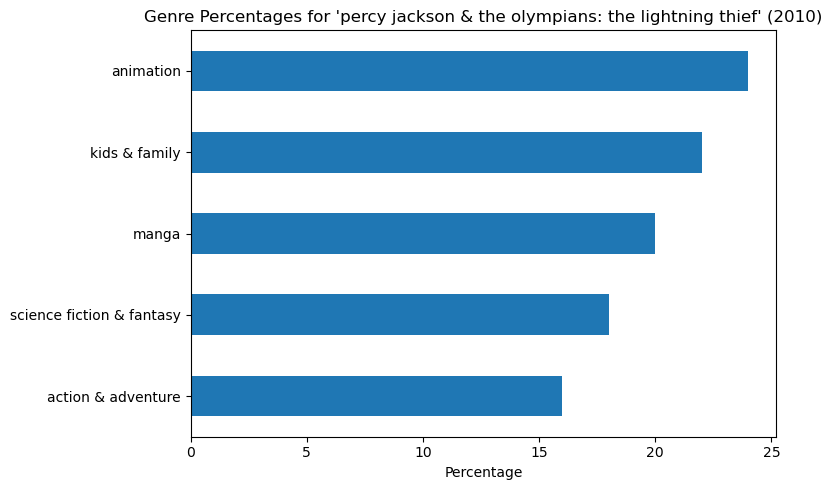


🎬 Genre Percentages (highest → lowest):
animation                    24.0
kids & family                22.0
manga                        20.0
science fiction & fantasy    18.0
action & adventure           16.0
Name: 0, dtype: object


In [20]:
from fuzzywuzzy import process
import matplotlib.pyplot as plt

# Build lowercase title → row mapping
title_map = {row["movie_title"].strip().lower(): row for idx, row in movie_genres_df.iterrows()}
all_titles = movie_genres_df["movie_title"].tolist()
lower_titles = [t.lower() for t in all_titles]
all_years = movie_genres_df["year"].tolist()

# Function to show genre plot sorted descending (highest at top)
def show_genre_plot(movie_title):
    row = title_map[movie_title.lower()]
    genre_cols = [c for c in movie_genres_df.columns if c not in ["movie_link","movie_title","year"]]
    genres = row[genre_cols].dropna()
    
    # Sort genres descending
    genres = genres.sort_values(ascending=False)
    
    plt.figure(figsize=(8,5))
    # Reverse order for barh to put highest at top
    genres[::-1].plot(kind='barh')
    plt.title(f"Genre Percentages for '{row['movie_title']}' ({row['year']})")
    plt.xlabel("Percentage")
    plt.tight_layout()
    plt.show()
    
    print("\n🎬 Genre Percentages (highest → lowest):")
    print(genres)

# Single search cycle
user_text = input("🎬 Enter movie name: ").strip()
user_text_lower = user_text.lower()

# Exact match
if user_text_lower in title_map:
    print(f"🎯 Exact match found: {title_map[user_text_lower]['movie_title']} ({title_map[user_text_lower]['year']})\n")
    show_genre_plot(title_map[user_text_lower]['movie_title'])
else:
    # Fuzzy suggestions
    suggestions = process.extract(user_text_lower, lower_titles, limit=5)
    print("❌ Exact match not found.\n🔎 Did you mean one of these?\n")
    
    for i, (suggestion_text, score) in enumerate(suggestions, start=1):
        idx = lower_titles.index(suggestion_text)
        real_title = all_titles[idx]
        year = all_years[idx]
        print(f"{i}. {real_title} ({year})  ({score}%)")
    
    # Ask user to select suggestion by number
    selection = input("\nType the number of the movie you want to select (or 0 to cancel): ").strip()
    if selection.isdigit():
        selection = int(selection)
        if 1 <= selection <= len(suggestions):
            idx = lower_titles.index(suggestions[selection-1][0])
            selected_title = all_titles[idx]
            print(f"\n🎯 You selected: {selected_title}\n")
            show_genre_plot(selected_title)
        else:
            print("❌ Selection cancelled.")
    else:
        print("❌ Invalid input. Selection cancelled.")


In [ ]:
# -------------------------------
# Full pipeline: Best dictionary + best topics
# -------------------------------

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# User parameters
# -------------------------------
texts = embedding_df["tokens"].tolist()
no_below_values = [5, 7, 10, 12]     # candidate no_below
no_above_values = [0.5, 0.6, 0.7]   # candidate no_above
topic_numbers = [8, 10, 12, 15]      # candidate topics for coherence
passes = 5                             # smaller passes for speed (coherence sweep)

results = []

# -------------------------------
# Run grid search
# -------------------------------
for nb, na in itertools.product(no_below_values, no_above_values):
    # 1️⃣ Build dictionary
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=nb, no_above=na)
    
    # 2️⃣ Build corpus
    corpus = [dictionary.doc2bow(doc) for doc in texts]
    
    # Skip if dictionary is too small
    if len(dictionary) < 50:
        continue
    
    # 3️⃣ Try different number of topics
    for num_topics in topic_numbers:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=passes,
            random_state=42,
            alpha='auto',
            eta='auto'
        )
        
        # 4️⃣ Compute coherence
        coherencemodel = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        
        # Store results
        results.append({
            "no_below": nb,
            "no_above": na,
            "num_topics": num_topics,
            "dictionary_size": len(dictionary),
            "coherence": coherence
        })
        
        print(f"✅ no_below={nb}, no_above={na}, topics={num_topics}, dict_size={len(dictionary)}, coherence={coherence:.4f}")

# -------------------------------
# Results DataFrame
# -------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("coherence", ascending=False).reset_index(drop=True)
display(results_df.head(10))  # show top 10 combinations

# -------------------------------
# Best combination
# -------------------------------
best = results_df.iloc[0]
print("\n🏆 Best dictionary + topic combination:")
print(f"no_below={best['no_below']}, no_above={best['no_above']}, num_topics={best['num_topics']}, dict_size={best['dictionary_size']}, coherence={best['coherence']:.4f}")

# -------------------------------
# Plot coherence heatmap
# -------------------------------
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    results_df.pivot_table(index='no_below', columns='no_above', values='coherence', aggfunc='max'),
    annot=True, fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Max coherence for different (no_below, no_above)")
plt.show()


In [ ]:
# -------------------------------
# Full pipeline: Best dictionary + best topics
# -------------------------------

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# User parameters
# -------------------------------
texts = embedding_df["tokens"].tolist()
no_below_values = [12, 15, 18, 20]     # candidate no_below
no_above_values = [0.5]   # candidate no_above
topic_numbers = [15, 20, 25, 30]      # candidate topics for coherence
passes = 5                             # smaller passes for speed (coherence sweep)

results = []

# -------------------------------
# Run grid search
# -------------------------------
for nb, na in itertools.product(no_below_values, no_above_values):
    # 1️⃣ Build dictionary
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=nb, no_above=na)
    
    # 2️⃣ Build corpus
    corpus = [dictionary.doc2bow(doc) for doc in texts]
    
    # Skip if dictionary is too small
    if len(dictionary) < 50:
        continue
    
    # 3️⃣ Try different number of topics
    for num_topics in topic_numbers:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=passes,
            random_state=42,
            alpha='auto',
            eta='auto'
        )
        
        # 4️⃣ Compute coherence
        coherencemodel = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        
        # Store results
        results.append({
            "no_below": nb,
            "no_above": na,
            "num_topics": num_topics,
            "dictionary_size": len(dictionary),
            "coherence": coherence
        })
        
        print(f"✅ no_below={nb}, no_above={na}, topics={num_topics}, dict_size={len(dictionary)}, coherence={coherence:.4f}")

# -------------------------------
# Results DataFrame
# -------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("coherence", ascending=False).reset_index(drop=True)
display(results_df.head(10))  # show top 10 combinations

# -------------------------------
# Best combination
# -------------------------------
best = results_df.iloc[0]
print("\n🏆 Best dictionary + topic combination:")
print(f"no_below={best['no_below']}, no_above={best['no_above']}, num_topics={best['num_topics']}, dict_size={best['dictionary_size']}, coherence={best['coherence']:.4f}")

# -------------------------------
# Plot coherence heatmap
# -------------------------------
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    results_df.pivot_table(index='no_below', columns='no_above', values='coherence', aggfunc='max'),
    annot=True, fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Max coherence for different (no_below, no_above)")
plt.show()


✅ no_below=15, no_above=0.5, topics=30, dict_size=21998, coherence=0.3878
✅ no_below=15, no_above=0.5, topics=35, dict_size=21998, coherence=0.3782
✅ no_below=15, no_above=0.5, topics=40, dict_size=21998, coherence=0.3770
✅ no_below=15, no_above=0.5, topics=45, dict_size=21998, coherence=0.3718


,no_below,no_above,num_topics,dictionary_size,coherence
0,15,0.5,30,21998,0.387806
1,15,0.5,35,21998,0.378229
2,15,0.5,40,21998,0.376996
3,15,0.5,45,21998,0.371838



🏆 Best dictionary + topic combination:
no_below=15.0, no_above=0.5, num_topics=30.0, dict_size=21998.0, coherence=0.3878


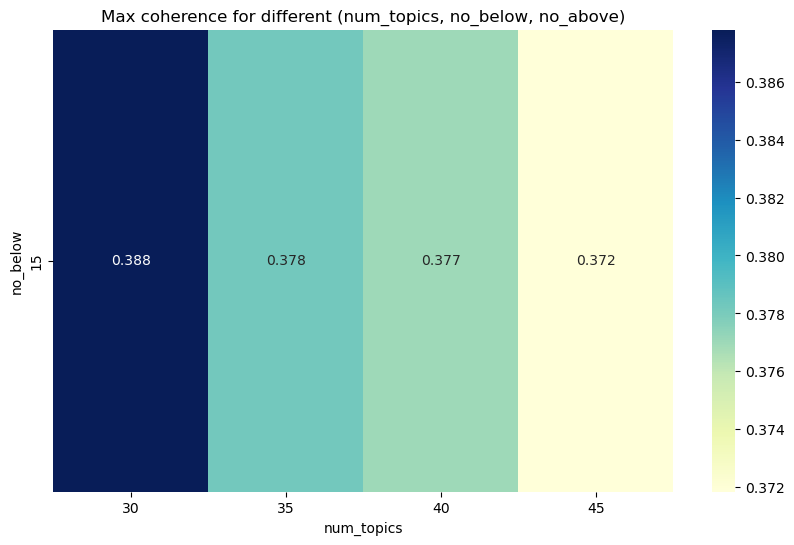

In [21]:
# -------------------------------
# Full pipeline: Best dictionary + best topics
# -------------------------------

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# -------------------------------
# User parameters
# -------------------------------
texts = embedding_df["tokens"].tolist()
no_below_values = [15]     # candidate no_below
no_above_values = [0.5]   # candidate no_above
topic_numbers = [30,35,40,45]      # candidate topics for coherence
passes = 5                             # smaller passes for speed (coherence sweep)

results = []

# -------------------------------
# Run grid search
# -------------------------------
for nb, na in itertools.product(no_below_values, no_above_values):
    # 1️⃣ Build dictionary
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=nb, no_above=na)
    
    # 2️⃣ Build corpus
    corpus = [dictionary.doc2bow(doc) for doc in texts]
    
    # Skip if dictionary is too small
    if len(dictionary) < 50:
        continue
    
    # 3️⃣ Try different number of topics
    for num_topics in topic_numbers:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=passes,
            random_state=42,
            alpha='auto',
            eta='auto'
        )
        
        # 4️⃣ Compute coherence
        coherencemodel = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        
        # Store results
        results.append({
            "no_below": nb,
            "no_above": na,
            "num_topics": num_topics,
            "dictionary_size": len(dictionary),
            "coherence": coherence
        })
        
        print(f"✅ no_below={nb}, no_above={na}, topics={num_topics}, dict_size={len(dictionary)}, coherence={coherence:.4f}")

# -------------------------------
# Results DataFrame
# -------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("coherence", ascending=False).reset_index(drop=True)
display(results_df.head(10))  # show top 10 combinations

# -------------------------------
# Best combination
# -------------------------------
best = results_df.iloc[0]
print("\n🏆 Best dictionary + topic combination:")
print(f"no_below={best['no_below']}, no_above={best['no_above']}, num_topics={best['num_topics']}, dict_size={best['dictionary_size']}, coherence={best['coherence']:.4f}")

# -------------------------------
# Plot coherence heatmap
# -------------------------------
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    results_df.pivot_table(index='no_below', columns='num_topics', values='coherence', aggfunc='max'),
    annot=True, fmt=".3f",
    cmap="YlGnBu"
)
plt.title("Max coherence for different (num_topics, no_below, no_above)")
plt.show()
